In [ ]:
import numpy as np
from scipy.integrate import dblquad,quad,nquad
import math
from numba import jit
from functools import lru_cache
import vegas


me=0.511
e=0.303
Z=57
l=10
# 这里sigma是坐标空间的
sigma_perp=100
sigma_z=5
P_z=5
b_perp=np.array([0,50,0])

# 定义 2x2 单位矩阵和泡利矩阵
I_2 = np.eye(2, dtype=np.complex128)
I_4 = np.eye(4, dtype=np.complex128)
sigma1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sigma3 = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# 定义 Gamma 矩阵
gamma0 = np.block([[I_2, np.zeros((2, 2))], [np.zeros((2, 2)), -I_2]])
gamma1 = np.block([[np.zeros((2, 2)), sigma1], [-sigma1, np.zeros((2, 2))]])
gamma2 = np.block([[np.zeros((2, 2)), sigma2], [-sigma2, np.zeros((2, 2))]])
gamma3 = np.block([[np.zeros((2, 2)), sigma3], [-sigma3, np.zeros((2, 2))]])


@jit(nopython=True, cache=True)
def w(theta,phi,s):
    res=np.array([[np.exp(-1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2)], [np.exp(1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)]], dtype=np.complex128)
    return res


@jit(nopython=True, cache=True)
def w_dagger(theta,phi,s):
    res=np.array([np.exp(1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2), np.exp(-1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)], dtype=np.complex128)
    return res

@lru_cache(maxsize=1000)
def u(epsilon, theta, phi, s):
    res= np.block([[np.sqrt(epsilon + me)*w(theta,phi,s)],[2*np.sqrt(epsilon - me)*s*w(theta,phi,s)]])
    return res  

@lru_cache(maxsize=1000)
def u_f(epsilon_f,theta_f,phi_f,s_f):
    res= np.block([np.sqrt(epsilon_f + me)*w_dagger(theta_f,phi_f,s_f),-2*np.sqrt(epsilon_f - me)*s_f*w_dagger(theta_f,phi_f,s_f)])
    return res

@lru_cache(maxsize=1000)
def photon_polar(lamb,theta_k,phi_k):
    return np.array([0,
                     1/np.sqrt(2)*(np.cos(theta_k)*np.cos(phi_k)-1j*lamb*np.sin(phi_k)),
                     1/np.sqrt(2)*(np.cos(theta_k)*np.sin(phi_k)-1j*lamb*np.cos(phi_k)),
                     1/np.sqrt(2)*np.sin(theta_k)], dtype=np.complex128)




@lru_cache(maxsize=1000)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    return np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])

@lru_cache(maxsize=1000)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    return np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])

@lru_cache(maxsize=1000)
def two_vec_mod(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    return np.sqrt(np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)])@np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)]))

@lru_cache(maxsize=1000)
def four_vec_slash(energy,m,theta,phi):
    four_vec_=four_vec(energy,m,theta,phi)
    res= four_vec_[0]*gamma0
    res +=-four_vec_[1]*gamma1
    res +=-four_vec_[2]*gamma2
    res +=-four_vec_[3]*gamma3
    return res

@lru_cache(maxsize=1000)
def photon_polar_slash(lamb,theta_k,phi_k):
    photon_polar_=photon_polar(lamb,theta_k,phi_k)
    res= photon_polar_[0]*gamma0
    res +=-photon_polar_[1]*gamma1
    res +=-photon_polar_[2]*gamma2
    res +=-photon_polar_[3]*gamma3
    return res
        

def M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):

    photon_polar_slash_=photon_polar_slash(lamb,theta_k,phi_k)
    four_vec_slash_k=four_vec_slash(omega,0,theta_k,phi_k)
    three_vec_i=three_vec(epsilon,me,theta,phi)
    three_vec_f=three_vec(epsilon_f,me,theta_f,phi_f)
    three_vec_k=three_vec(omega,0,theta_k,phi_k)

    res=(4*np.pi)**(3/2)*Z*e**3/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                        u_f(epsilon_f,theta_f,phi_f,s_f)@\
                        (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                        (four_vec_slash(epsilon_f,me,theta_f,phi_f)+four_vec_slash_k+me*I_4)@gamma0\
                        +\
                        1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                        (four_vec_slash(epsilon,me,theta,phi)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                        u(epsilon,theta,phi,s)
    return res[0]


def Phi_cap(epsilon,theta,phi,l):
    two_vec_mod_=two_vec_mod(epsilon,me,theta,phi)
    res= (4*np.pi)**(3/4)*np.sqrt(epsilon)*sigma_perp*np.sqrt(sigma_z)*(sigma_perp*two_vec_mod_)**(abs(l))/np.sqrt(math.factorial(abs(l)))\
       *np.exp(-sigma_perp**2*two_vec_mod_**2/2)*np.exp(-sigma_z**2*(np.sqrt(epsilon**2-me**2)*np.cos(theta)-P_z)**2/2)*np.exp(1j*l*phi)
    return res


def var_L_pre(theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):
    epsilon=epsilon_f+omega
    res=np.pi/(2*np.pi)**(3)*np.sin(theta)*Phi_cap(epsilon,theta,phi,l)*np.exp(-1j*b_perp@three_vec(epsilon,me,theta,phi))\
        *M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb)
    return res


# def var_L(s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb):
#     # 定义内层积分函数(对 phi 积分)
#     def inner_integral(theta):
#         def integrand(phi):
#             val = var_L_pre(theta, phi, s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb)
#             return val.real, val.imag  # 直接返回实部和虚部
        
#         # 用 quad 计算实部和虚部的积分
#         result_real, _ = quad(lambda phi: integrand(phi)[0], 0, 2 * np.pi)
#         result_imag, _ = quad(lambda phi: integrand(phi)[1], 0, 2 * np.pi)
#         return result_real + 1j * result_imag

#     # 对 theta 进行积分
#     result_real, error_real = quad(lambda theta: inner_integral(theta).real, 0, np.pi)
#     result_imag, error_imag = quad(lambda theta: inner_integral(theta).imag, 0, np.pi)

#     # 返回最终复数积分值
#     result = result_real + 1j * result_imag
#     error = error_real + 1j * error_imag
#     return [result, error]


def var_L(s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb, N_theta=100, N_phi=300):
    """ 使用梯形法计算复数二重积分 """
    
    # 生成 θ 和 φ 的均匀网格点
    theta_vals = np.linspace(0, 0.015, N_theta)  # θ 从 0 到 π
    phi_vals   = np.linspace(0, 2*np.pi, N_phi)  # φ 从 0 到 2π

    # 计算函数值的网格存放
    F_vals = np.zeros((N_theta, N_phi), dtype=np.complex128)  # 复数数组
    
    # 遍历网格, 计算 var_L_pre
    for i, theta in enumerate(theta_vals):
        for j, phi in enumerate(phi_vals):
            F_vals[i, j] = var_L_pre(theta, phi, s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb)

    # **第一步: 先对 phi 方向进行梯形法积分**
    int_phi = np.trapz(F_vals, phi_vals, axis=1)  # 对每个 theta 积分

    # **第二步: 再对 theta 方向进行梯形法积分**
    integral = np.trapz(int_phi, theta_vals)
    
    return integral




# omega0=2
# # 定义积分域
# epsilon_f_min, epsilon_f_max =me+0.001 , np.sqrt(P_z**2+me**2)+2
# theta_f_min, theta_f_max = 0, np.pi
# phi_f_min, phi_f_max = 0, 2 * np.pi
# theta_k_min, theta_k_max = 0, np.pi
# phi_k_min, phi_k_max = 0, 2 * np.pi

# # 定义被积函数 (注意: vegas 传递的是一个包含5个值的输入 x)
# def integrand(x):
#     epsilon_f, theta_f, phi_f, theta_k, phi_k = x  # 解包变量

#     # 计算 var_L
#     var_l = var_L(s=1, epsilon_f=epsilon_f, theta_f=theta_f,
#                   phi_f=phi_f, s_f=1, omega=omega0, 
#                   theta_k=theta_k, phi_k=phi_k, lamb=1)[0]
    
#     # 返回被积函数值
#     return np.sin(theta_k) * np.sin(theta_f) * abs(var_l)**2  

# # 定义 vegas 积分器
# integ = vegas.Integrator([
#     [epsilon_f_min, epsilon_f_max],   # epsilon_f
#     [theta_f_min, theta_f_max],       # theta_f
#     [phi_f_min, phi_f_max],           # phi_f
#     [theta_k_min, theta_k_max],       # theta_k
#     [phi_k_min, phi_k_max]            # phi_k
# ])

# # 训练阶段 (可以调整 nitn 次数)
# integ(integrand, nitn=5, neval=100)

# # 计算积分 (最终评估)
# result = integ(integrand, nitn=2, neval=1000)

# 输出结果
# print("积分结果:", result, "误差:", result.sdev)

#积分结果: nitn=2, neval=1000 1.77(53)e+04 误差: 5343.452927090847

print(var_L(0.5,1.026,np.pi/4,np.pi/3,0.5,4,np.pi/3,np.pi/3,1))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.block' or unsupported use of the function.
[1m
File "C:\Users\HP\AppData\Local\Temp\ipykernel_11664\1167372022.py", line 46:[0m
[1mdef u(epsilon, theta, phi, s):
[1m    return np.block([[np.sqrt(epsilon + me) * w(theta, phi, s)],
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\HP\AppData\Local\Temp\ipykernel_11664\1167372022.py (46)[0m
[1m
File "C:\Users\HP\AppData\Local\Temp\ipykernel_11664\1167372022.py", line 46:[0m
[1mdef u(epsilon, theta, phi, s):
[1m    return np.block([[np.sqrt(epsilon + me) * w(theta, phi, s)],
[0m    [1m^[0m[0m


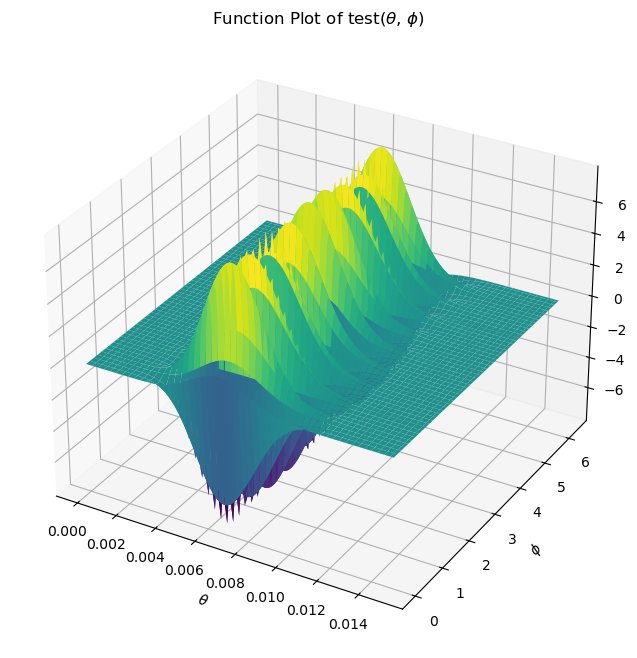

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def test(theta,phi):
    res=var_L_pre(theta,phi,0.5,1.026,np.pi/3,np.pi/3,0.5,4,np.pi/3,np.pi/3,1)
    return res.imag


# 生成 theta 和 phi 的数据
theta_vals = np.linspace(0, 0.015, 100)  # 从 0 到 pi
phi_vals = np.linspace(0, 2*np.pi, 100)  # 从 0 到 2*pi
theta, phi = np.meshgrid(theta_vals, phi_vals)

# 计算 test 函数值
# 用 numpy 的 `frompyfunc` 确保 `test` 逐元素计算
z = np.frompyfunc(test, 2, 1)(theta, phi).astype(np.float64)  # 关键部分


# 创建图形
fig = plt.figure(figsize=(10, 8))

# 选择绘制方式(取消注释你想要的)

## 方式 1: 3D 曲面图
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta, phi, z, cmap='viridis')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'test($\theta$, $\phi$)')

## 方式 2: 等高线图(如果需要 2D 视图)
# ax = fig.add_subplot(111)
# contour = ax.contourf(theta, phi, z, levels=50, cmap='viridis')
# fig.colorbar(contour)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel(r'$\phi$')

plt.title("Function Plot of test($\\theta$, $\\phi$)")
plt.show()
